[*********************100%***********************]  1 of 1 completed

Price          Adj Close         Close          High           Low  \
Ticker     TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
Date                                                                 
2010-01-04    152.195312    163.535919    164.040497    156.184769   
2010-01-05    149.543472    160.686478    167.147186    153.246277   
2010-01-06    149.773666    160.933823    162.932388    159.311234   
2010-01-07    144.654160    155.432831    161.923218    154.344498   
2010-01-08    145.446030    156.283707    159.251862    155.343781   

Price               Open        Volume  
Ticker     TATAMOTORS.NS TATAMOTORS.NS  
Date                                    
2010-01-04    156.303482      27906448  
2010-01-05    162.259598      23669317  
2010-01-06    162.200241      14990820  
2010-01-07    161.171280      22722030  
2010-01-08    156.323273      16495776  
Epoch 1/15



C:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0141
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0020
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0018
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0016
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0014
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0015
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0014
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0012
Epoch 9/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0011
Epoch 10/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0011
Epoch 11/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0012
Epoch 12/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0011
Epoch 13/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 9.5698e-04
Epoch 14/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 8.3949e-04
Epoch 15/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48

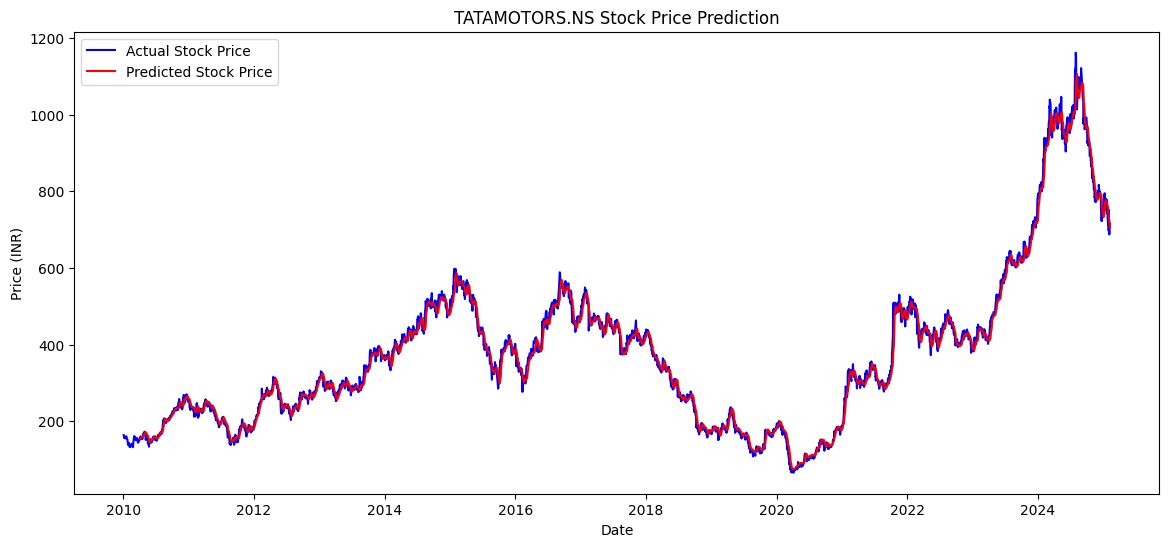

In [2]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Fetch Historical Stock Data
ticker = 'TATAMOTORS.NS'  # Replace with any Indian stock ticker (e.g., 'TATAMOTORS.BO' for BSE)

# Define the date range
start_date = '2010-01-01'
end_date = '2025-02-09'

# Download stock data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Show the first few rows of the data
print(data.head())

# 2. Preprocessing the Data (MinMax Scaling)
data = data[['Close']]  # Use only the 'Close' price for prediction

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for the model
def prepare_data(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60  # Look-back period (60 days)
X, y = prepare_data(scaled_data, time_step)

# Reshape X for LSTM input [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# 3. Build the LSTM Model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X, y, epochs=15, batch_size=32, callbacks=[early_stopping])

# 4. Make Predictions

# Get the last 60 days of stock data for prediction
test_data = data[-time_step:].values
test_data = scaler.transform(test_data)
X_test = []
X_test.append(test_data)
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict the stock price for the next day
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)  # Unscale the predicted price

print(f"Predicted next day's stock price for {ticker}: {predicted_price[0][0]} INR")

# 5. Plot the Results

# Predict on the entire dataset for visualization
full_data = data[['Close']].values
scaled_full_data = scaler.fit_transform(full_data)

X_full, y_full = prepare_data(scaled_full_data, time_step)
X_full = X_full.reshape(X_full.shape[0], X_full.shape[1], 1)
predicted_prices = model.predict(X_full)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Actual Stock Price', color='blue')
plt.plot(data.index[time_step:], predicted_prices, label='Predicted Stock Price', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()
